In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
data = sm.datasets.macrodata.load_pandas().data
print(data.shape)
data.head(5)

(203, 14)


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [2]:
data1 = data[["realgdp", 'realdpi']]
data1.index = data["year"]
data1.head(5)

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


<AxesSubplot:xlabel='year'>

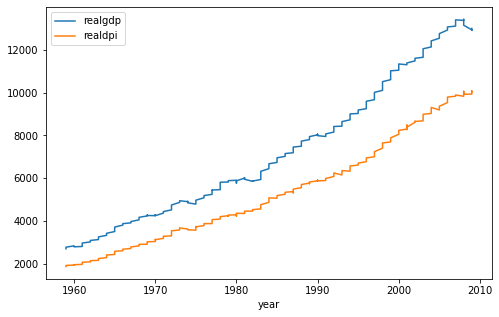

In [3]:
data1.plot(figsize = (8,5))

Before applying VAR, both the time series variable should be stationary. Both the series are not stationary since both the series do not show constant mean and variance over time. We can also perform a statistical test like the Augmented Dickey-Fuller test (ADF) to find stationarity of the series using the AIC criteria.

In [4]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647144
p-value: 0.9982455372335032


In [5]:
adfuller_test = adfuller(data1['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.986025351954683
p-value: 1.0


In [6]:
# realgdp series becomes stationary after 1st differencing
data_d = data1.diff().dropna()
adfuller_test = adfuller(data_d['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [7]:
# realdpi series becomes stationary after 1st differencing
adfuller_test = adfuller(data_d['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.864893340673007
p-value: 1.4493606159108096e-14


In [8]:
# train-test split of the data and keep the last 10-days as test data
nobs = 10
train = data_d.iloc[:-nobs,:]
test = data_d.iloc[-nobs:,:]

In the process of VAR modeling, we opt to employ Information Criterion Akaike (AIC) as a model selection criterion to conduct optimal model identification. In simple terms, we select the order (p) of VAR based on the best AIC score. The AIC, in general, penalizes models for being too complex, though the complex models may perform slightly better on some other model selection criterion. Hence, we expect an inflection point in searching the order (p), meaning that, the AIC score should decrease with order (p) gets larger until a certain order and then the score starts increasing. For this, we perform grid-search to investigate the optimal order (p).

In [9]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/home/tom/econometrics-gdp-dpi-VAR/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# From visual judgement, it seems should be 2
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [11]:
# auto selection of best lag can be different than from visual judgement
forecasting_model.select_order(10)
results_auto = forecasting_model.fit(maxlags = 10, ic = "aic")
lag_order = results_auto.k_ar
lag_order

3

In [12]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Mar, 2022
Time:                     13:05:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

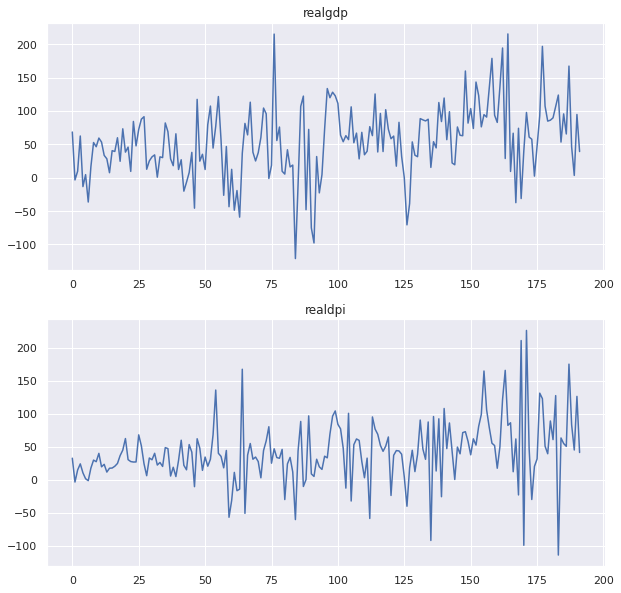

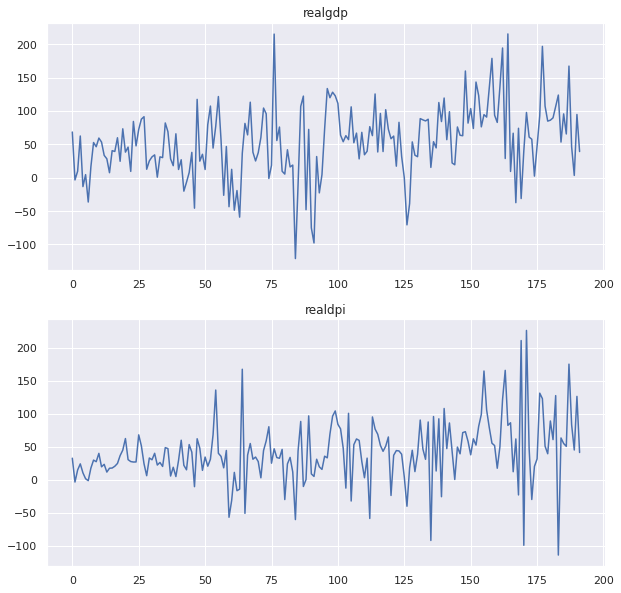

In [13]:
results.plot()

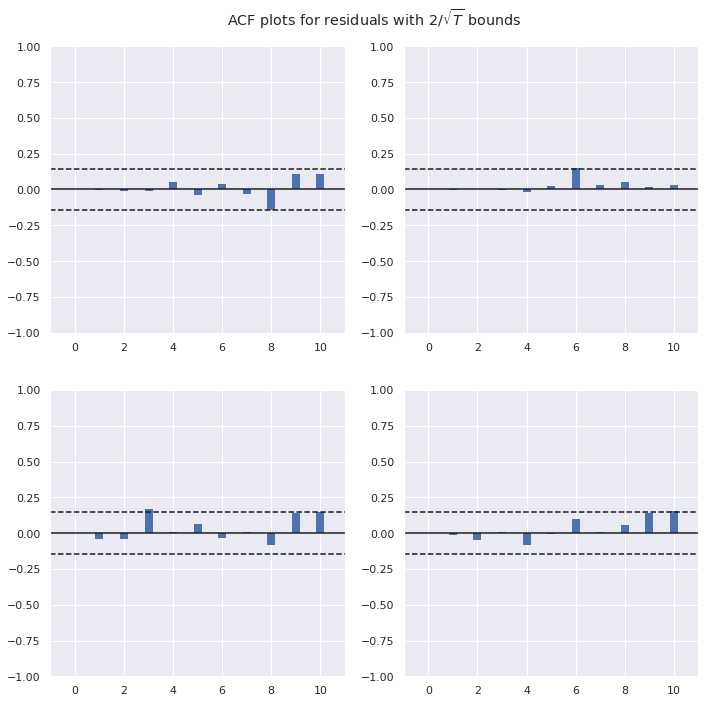

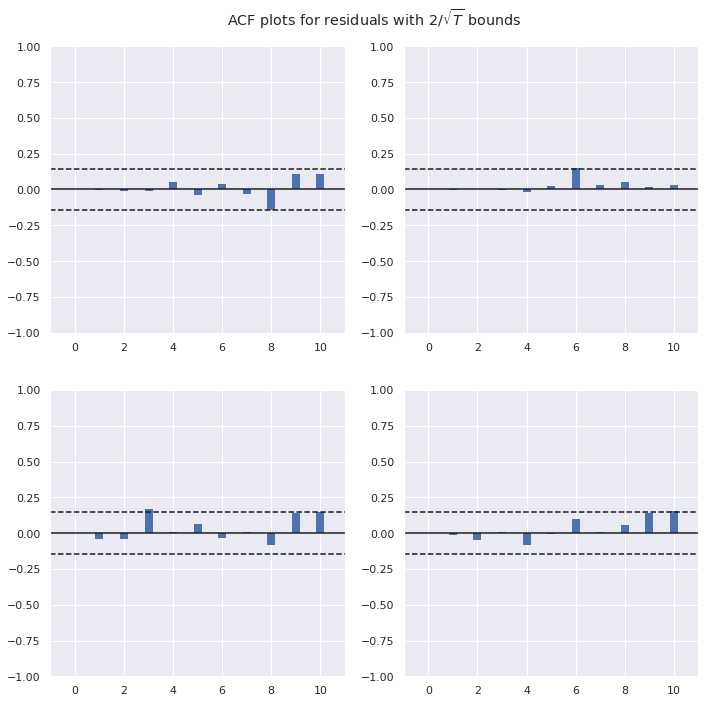

In [14]:
results.plot_acorr()

We use 2 as the optimal order in fitting the VAR model. Thus, we take the final 2 steps in the training data for forecasting the immediate next step (i.e., the first day of the test data). Now, after fitting the model, we forecast for the test data where the last 2 days of training data set as lagged values and steps set as 10 days as we want to forecast for the next 10 days.

In [15]:
train.values[-2:]

array([[ 94.763, 126.3  ],
       [ 39.222,  41.4  ]])

In [16]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


We have to note that the aforementioned forecasts are for the one differenced model. Hence, we must reverse the first differenced forecasts into the original forecast values.


In [17]:
forecast_1D = forecast.copy()
forecast["realgdp_forecasted"] = data1["realgdp"].iloc[-10-1] + forecast_1D['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = data1["realdpi"].iloc[-10-1] + forecast_1D['realdpi_1d'].cumsum()
forecast 

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


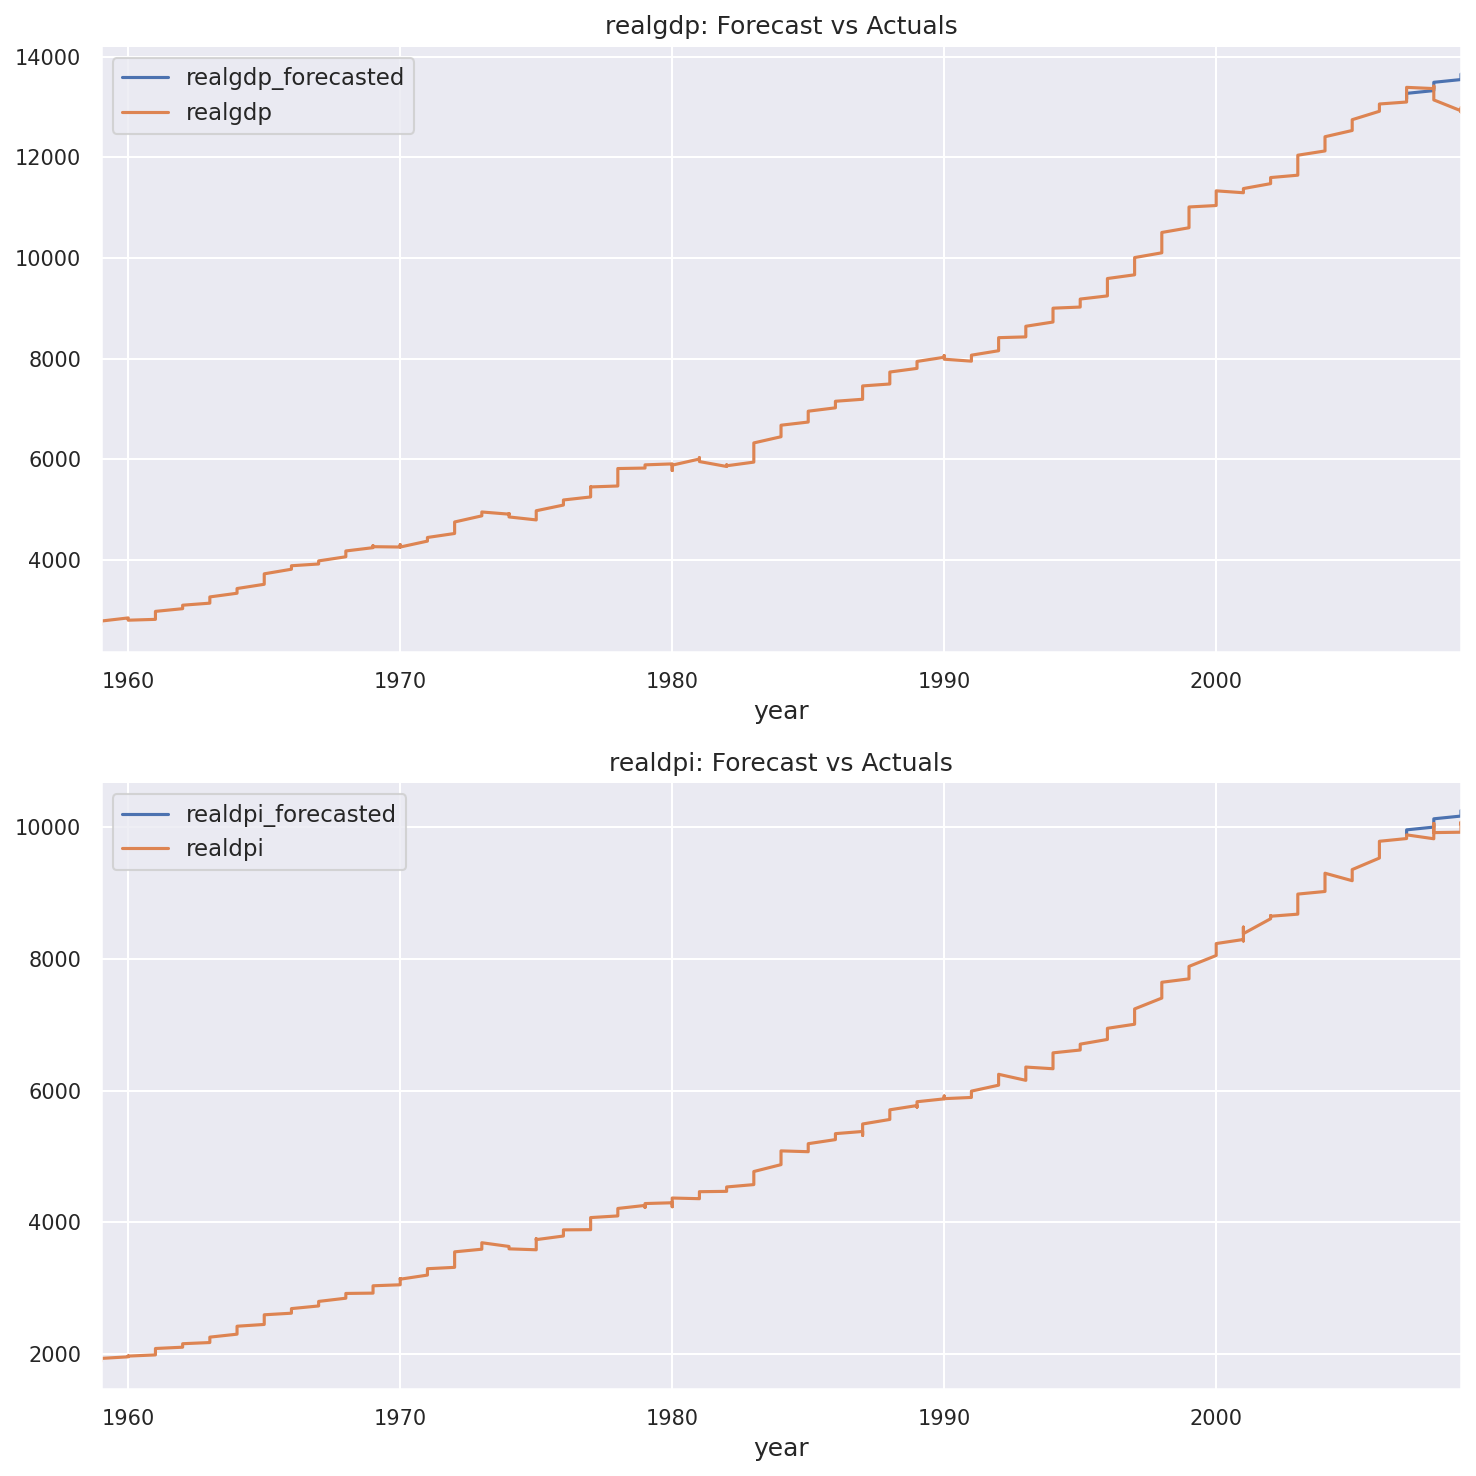

In [18]:
# plot forecast vs. actuals
fig, axes = plt.subplots(nrows=int(len(data1.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data1.columns, axes.flatten())):
    forecast[col+'_forecasted'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data1[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout()

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables. They are computed in practice using the MA(∞) representation of the VAR(p) process:
These can be visualized using the plot function, in either orthogonalized or non-orthogonalized form. Asymptotic standard errors are plotted by default at the 95% significance level, which can be modified by the user.

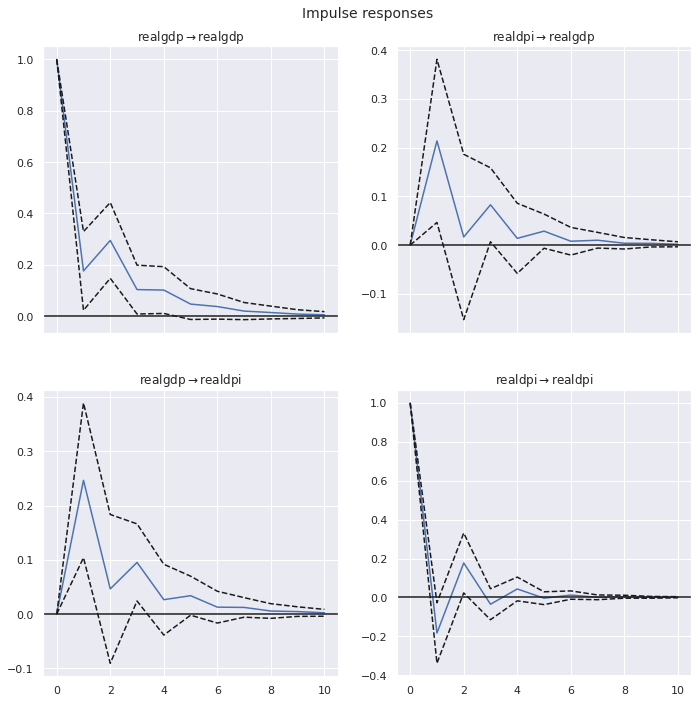

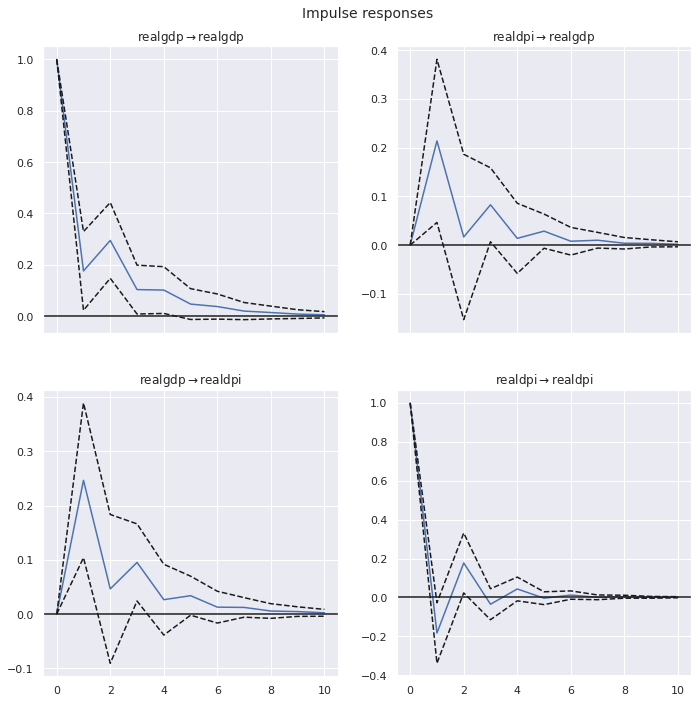

In [19]:
irf = results.irf(10)
irf.plot(orth=False)

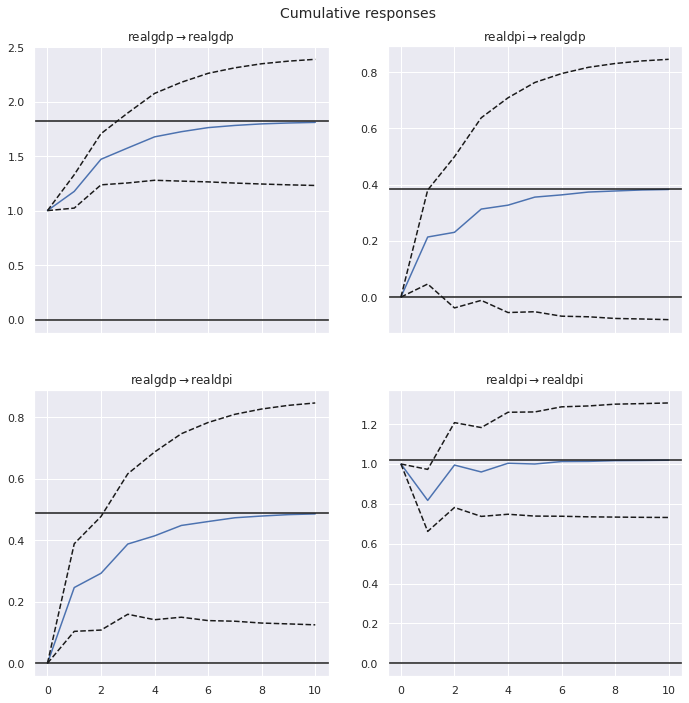

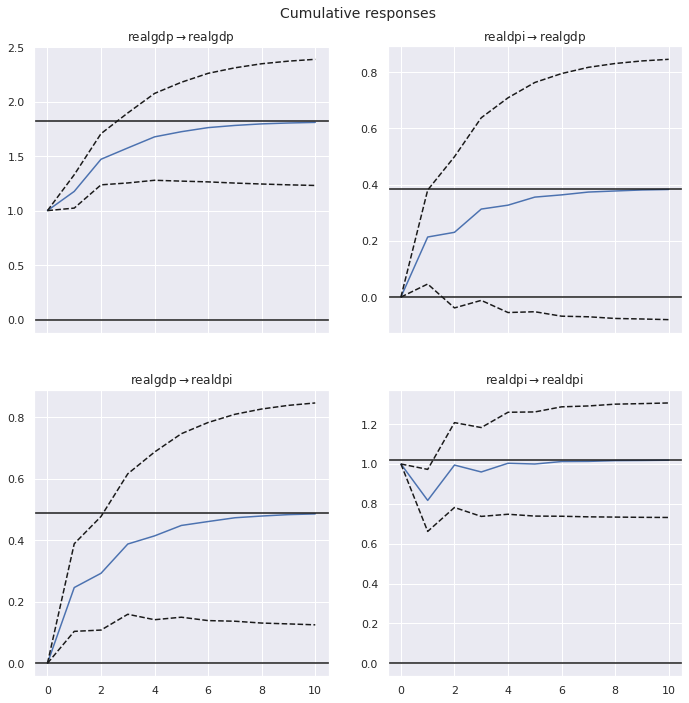

In [20]:
irf.plot_cum_effects(orth=False)

Forecast Error Variance Decomposition (FEVD)
Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses Θ𝑖:

In [21]:
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp   realdpi
0    1.000000  0.000000
1    0.969347  0.030653
2    0.971515  0.028485
3    0.967893  0.032107
4    0.968080  0.031920

FEVD for realdpi
      realgdp   realdpi
0    0.149513  0.850487
1    0.175578  0.824422
2    0.181783  0.818217
3    0.187401  0.812599
4    0.188625  0.811375




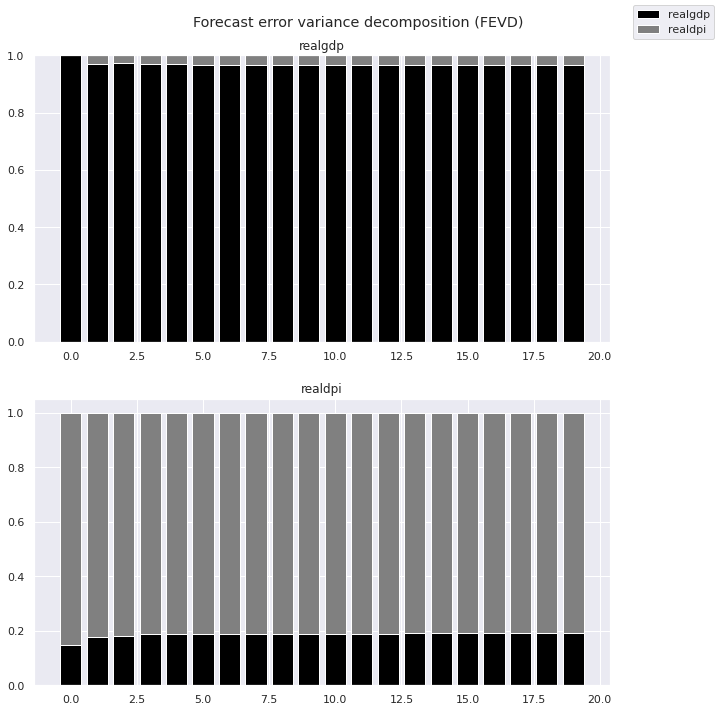

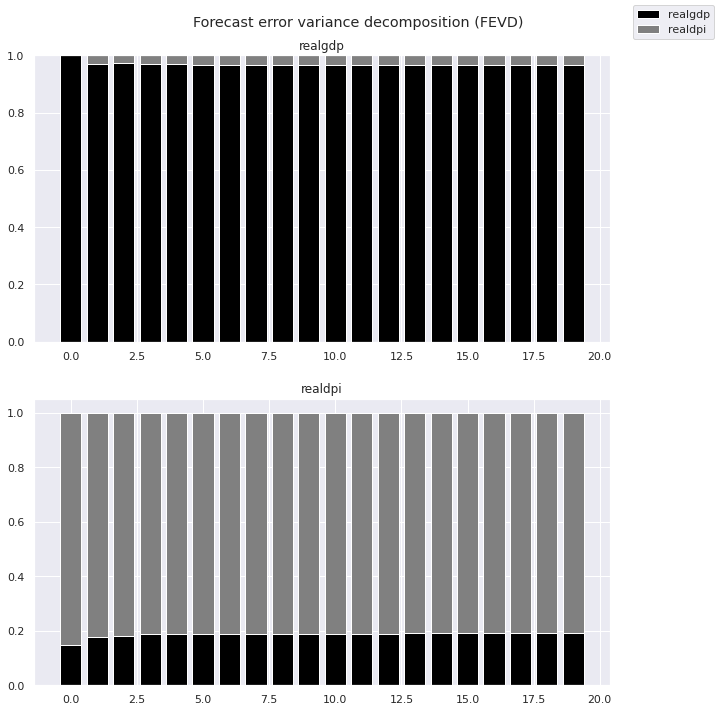

In [22]:
results.fevd(20).plot()

Granger causality
One is often interested in whether a variable or group of variables is “causal” for another variable, for some definition of “causal”. In the context of VAR models, one can say that a set of variables are Granger-causal within one of the VAR equations. We will not detail the mathematics or definition of Granger causality, but leave it to the reader. The VARResults object has the test_causality method for performing either a Wald (𝜒2) test or an F-test.

In [23]:
print(results.test_causality('realgdp', 'realdpi', kind='f'))
print(results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: realdpi does not Granger-cause realgdp: reject at 5% significance level. Test statistic: 3.273, critical value: 3.020>, p-value: 0.039>
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 116.705, critical value: 9.488>, p-value: 0.000>


The following is Bayesian Based Vector Autoregression: The Bayesian approach offers a probabilistic approach to time series to reduce uncertainty and incorporate “prior” information. These models are referred to as Dynamic Linear Models or Structural Time Series (state space models). They work by fitting the structural changes in a time series dynamically — in other words, evolving and updating the model parameters over time with the addition of new information. In contrast, VAR estimates parameters for the series, which remain fixed, then uses Maximum Likelihood estimation for determining the time series predictions. Bayesian methods use MCMC (Monte Carlo Markov Chains) to generate estimates from distributions. It’s a one-step-ahead prediction starting from the beginning of the series and updating each parameter as you move through the series. Therefore, each step-ahead is actually a true “out-of-sample prediction”, and thus there error from the prediction reflects true out-of-sample estimates based on the posterior probabilities. For ARIMA to do this, you would need to specify a hold-out sample at the end of your series, then implement a for-loop that iterates of each data point in the hold-out sample, update the model, move to the next point, update the model.

In [8]:
from scipy import stats
#import pmdarima as pmd
import pybats
from pybats.loss_functions import MAPE
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import *

Three problems could be for VAR models, 1. the data is not stationary, 2. there appears to be a possible seasonal effect, 3. the variance increases with time. for BVAR, these would be not a problem. So we can use data2, not datad here for BVAR model. These are in general belonging to a group of BSTS(Bayesian Structured Time Series).

<AxesSubplot:xlabel='year'>

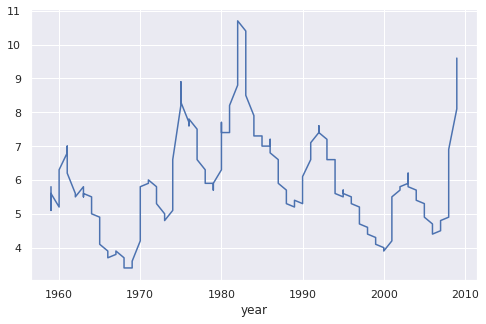

In [41]:
data2 = data[["realgdp", 'realdpi', 'realcons',	'realinv',	'realgovt',	'cpi',	'm1', 'tbilrate', 'unemp']]
data2.index = data["year"]
data2["unemp"].plot(figsize = (8,5))

beginning forecasting
MAPE: 11.53


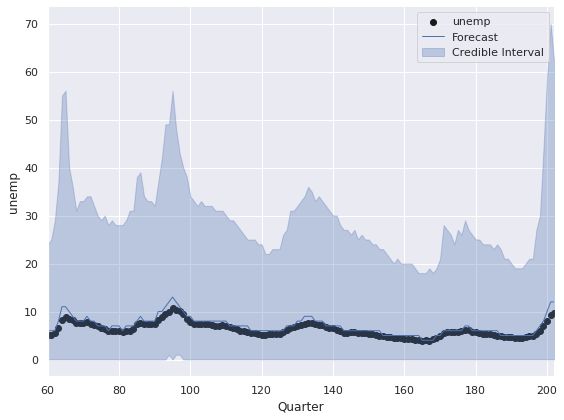

In [242]:
def bayes_forecast(iv,dv):
    '''
    This functions runs the Pybats algorithm by taking two parameters: an independent variable
    matrix and a dependent variable. Both elements must be sequential time series. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    if iv is None:
        x = None
    else:
        x = iv.values    
    y = dv.values    
    # set the one-step-ahead value; by default we want 1
    k = 1                                                       
    forecast_start = 60                                         
    forecast_end = len(y)-1    
    mod, samples = analysis(Y=y, X=x, family='poisson',
                            forecast_start=forecast_start,      
                            forecast_end=forecast_end,         
                            k=k,                                
                            ntrend=2,
                            nsamps=5000,
                            seasPeriods=[4],
                            seasHarmComponents=[[1,2]],
                            prior_length=22,                     
                            deltrend=0.99,                      
                            delregn=0.90,                        
                            delVar=0.98,
                            delSeas=0.99,
                            rho=.6,
                            )                            
    forecast = median(samples)
    # set confidence interval for in-sample forecast
    credible_interval=95
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
    print("MAPE:", MAPE(y[forecast_start:forecast_end+k], forecast[:]).round(2))
    # Plot the 1-step ahead point forecast plus the 95% credible interval
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))   
    ax = plot_data_forecast(fig, ax, y[forecast_start:forecast_end + k], forecast, samples,
                            dates=np.arange(forecast_start, forecast_end+1, dtype='int'))
    ax = ax_style(ax, ylabel=dv.name, xlabel='Quarter', xlim=[forecast_start, forecast_end],
                  legend=[dv.name, 'Forecast', 'Credible Interval'])
    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y

mv_mod, mv_for, mv_samp, mv_y = bayes_forecast(data2.iloc[:, [5, 8]], data2.unemp)

In [226]:
print(mv_mod.get_coef())

           Mean  Standard Deviation
Intercept  2.45                2.22
Regn 1    -0.00                0.00
Regn 2     0.00                0.00
Seas 1     0.00                0.08
Seas 2     0.00                0.08
Seas 3    -0.00                0.05
Seas 4     0.00                1.00


The Python function above can also run the equivalent model without the covariate(s) — so a standard univariate time series. We’re doing this to determine if including the independent variable(s)(in this case GDP) in the model is having the intended effect of reducing the overall residual error in the model. In other words, does including the GDP variable improve our understanding of the data; is it worth including them in the model?

beginning forecasting
MAPE: 18.03


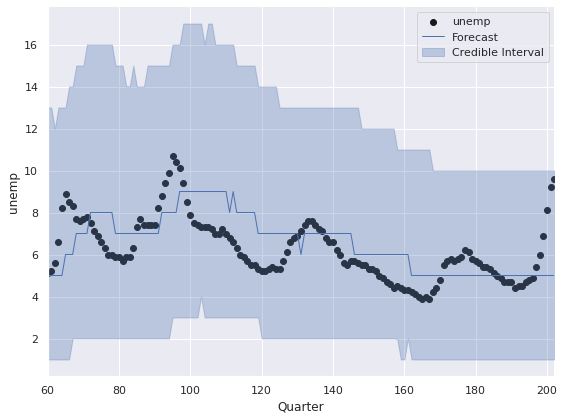

In [243]:
# Calculate Bayesian estimate for the univariate model
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(None, data2.unemp)

The above is a one-step-ahead prediction starting from the beginning of the series and updating each parameter as you move through the series. Therefore, each step-ahead is actually a true “out-of-sample prediction”, and thus there error from the prediction reflects true out-of-sample estimates based on the posterior probabilities. The plot below compares the cumulative error between the two models (univariate and multivariate). It shows that the covariates begin to explain more of the variability in the time series model as time progresses — which is what we would expect as the model learns and adjusts the parameters based on previous values.